In [ ]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201206_bootstrap/6000_clusters"

In [ ]:
# ## Only needed to run once to create and save the labels

# def create_clusters(brain, n_clusters):
#     t0 = time.time()
#     clustering_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201110_analysis_superfly_supervoxels"
#     super_to_cluster = brain.reshape(-1, 33840)
#     connectivity = grid_to_graph(256,128)
#     cluster_model = AgglomerativeClustering(n_clusters=n_clusters,
#                                     memory=clustering_dir,
#                                     linkage='ward',
#                                     connectivity=connectivity)
#     cluster_model.fit(super_to_cluster)
#     print('Duration: {}'.format(time.time()-t0))
#     return cluster_model

# labels = []
# for z in range(49):
#     print(z)
#     t0 = time.time()
#     brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z)
#     brain = np.array(nib.load(brain_file).get_data(), copy=True)
#     print(f'Duration: {time.time()-t0}')

#     n_clusters = 6000
#     cluster_model = create_clusters(brain, n_clusters)
#     labels.append(cluster_model.labels_)
    
# save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels_6000'
# np.save(save_file, np.asarray(labels))

0
Duration: 18.163174629211426
Duration: 48.85188436508179
1
Duration: 12.706199169158936
Duration: 48.02363133430481
2
Duration: 17.387316942214966
Duration: 50.302332401275635
3
Duration: 12.0087571144104
Duration: 47.56140089035034
4
Duration: 12.743913412094116
Duration: 52.00115489959717
5
Duration: 12.030763149261475
Duration: 46.936951875686646
6
Duration: 16.759185552597046
Duration: 47.72442150115967
7
Duration: 14.966772317886353
Duration: 46.046281576156616
8
Duration: 16.507084608078003
Duration: 48.92775869369507
9
Duration: 12.902281045913696
Duration: 45.95470714569092
10
Duration: 12.525606393814087
Duration: 47.32974982261658
11
Duration: 18.893065690994263
Duration: 46.621644496917725
12
Duration: 12.206940412521362
Duration: 48.794029235839844
13
Duration: 11.904396295547485
Duration: 46.48113179206848
14
Duration: 14.195605278015137
Duration: 48.00711798667908
15
Duration: 14.142555952072144
Duration: 47.88699173927307
16
Duration: 12.383443117141724
Duration: 47.50

In [7]:
n_clusters = 6000
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels_6000.npy'
labels = np.load(labels_file)

In [3]:
# n_clusters = 2000
# labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
# labels = np.load(labels_file)

In [9]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/luke.nii'
anatomy = np.asarray(nib.load(file).get_data(), dtype='float32')/1

In [21]:
# analysis = 'correlation_Z_pos_Z_neg'
# alpha_min = .03
# alpha_max = .07
# norm_min = .03
# norm_max = .14

#analysis = 'correlation_Y_pos_None'
#analysis = 'correlation_Y_neg_None'
#analysis = 'correlation_Z_pos_None'
#analysis = 'correlation_Z_neg_None'

#analysis = 'state_stop_times_moving_times'
#analysis = 'state_stop_times_forward_times'
#analysis = 'state_forward_times_rotation_neg_times'
#analysis = 'state_forward_times_rotation_pos_times'

#analysis = 'no_bootstrap_Y_pos_None'
#analysis = 'no_bootstrap_Y_neg_None'
#analysis = 'no_bootstrap_Z_pos_None'
analysis = 'no_bootstrap_Z_neg_None'

#analysis = 'no_bootstrap_Y_pos_None'

values_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if '{}_values'.format(analysis) in x]
bbb.sort_nicely(values_to_load)

sig_to_load = [os.path.join(dataset_path, x) for x in os.listdir(dataset_path) if '{}_sigs'.format(analysis) in x]
bbb.sort_nicely(sig_to_load)

In [22]:
value_map = []
sig_map = []
for z in range(49):
    value_map.append(np.load(values_to_load[z]))
    sig_map.append(np.load(sig_to_load[z]))
    
value_map = np.asarray(value_map)
sig_map = np.asarray(sig_map)

In [23]:
### For sigs from scipy pearsonsr (ie, very small p values possible)
final_map = []
for z in range(49):
    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(labels[z,:]==cluster_num)[0]

        if sig_map[z,cluster_num] <= 1e-8 :
            sig = 1
        else:
            sig = 0

        if len(cluster_indicies) > 100:
            sig = np.nan
        colored_by_betas[cluster_indicies] = value_map[z,cluster_num]*sig
    colored_by_betas = colored_by_betas.reshape(256,128)
    final_map.append(colored_by_betas)
final_map = np.asarray(final_map)

In [16]:
map_y_pos = final_map.copy()

In [20]:
map_z_pos = final_map.copy()

In [24]:
map_z_neg = final_map.copy()

In [25]:
map_y_pos_smo = scipy.ndimage.gaussian_filter(np.nan_to_num(map_y_pos),sigma=.7)
map_z_pos_smo = scipy.ndimage.gaussian_filter(np.nan_to_num(map_z_pos),sigma=.7)
map_z_neg_smo = scipy.ndimage.gaussian_filter(np.nan_to_num(map_z_neg),sigma=.7)

In [454]:
map_y_pos.shape

(49, 256, 128)

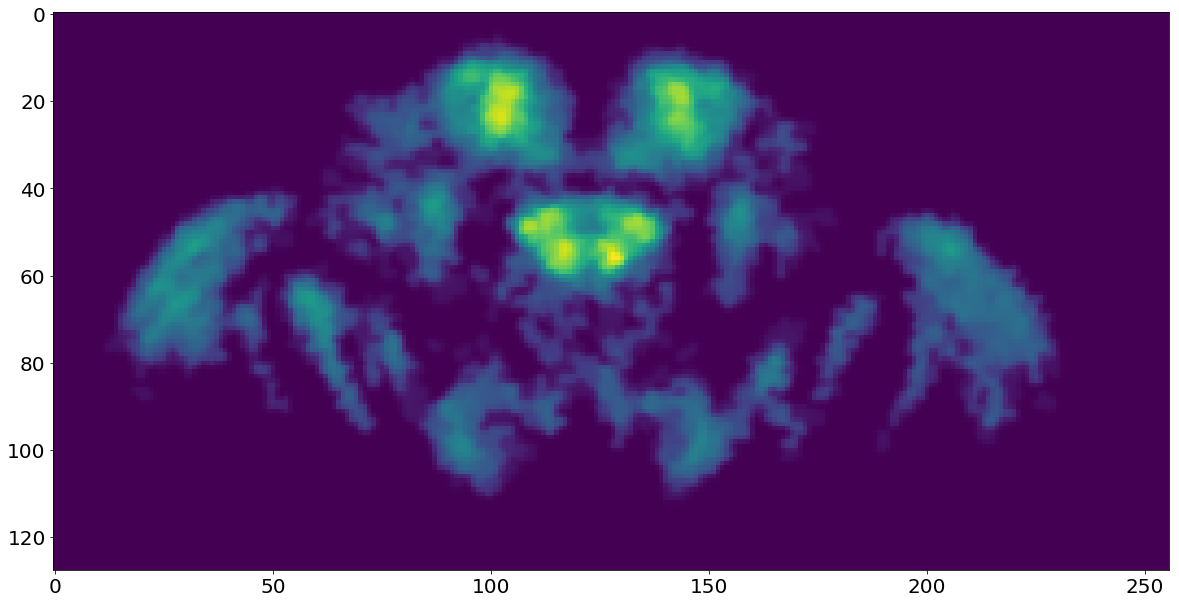

In [472]:
map_y_pos_smo = scipy.ndimage.gaussian_filter(np.nan_to_num(map_y_pos),sigma=.7)

fig = plt.figure(figsize=(20,20))
plt.imshow(map_y_pos_smo[20,:,:].T)

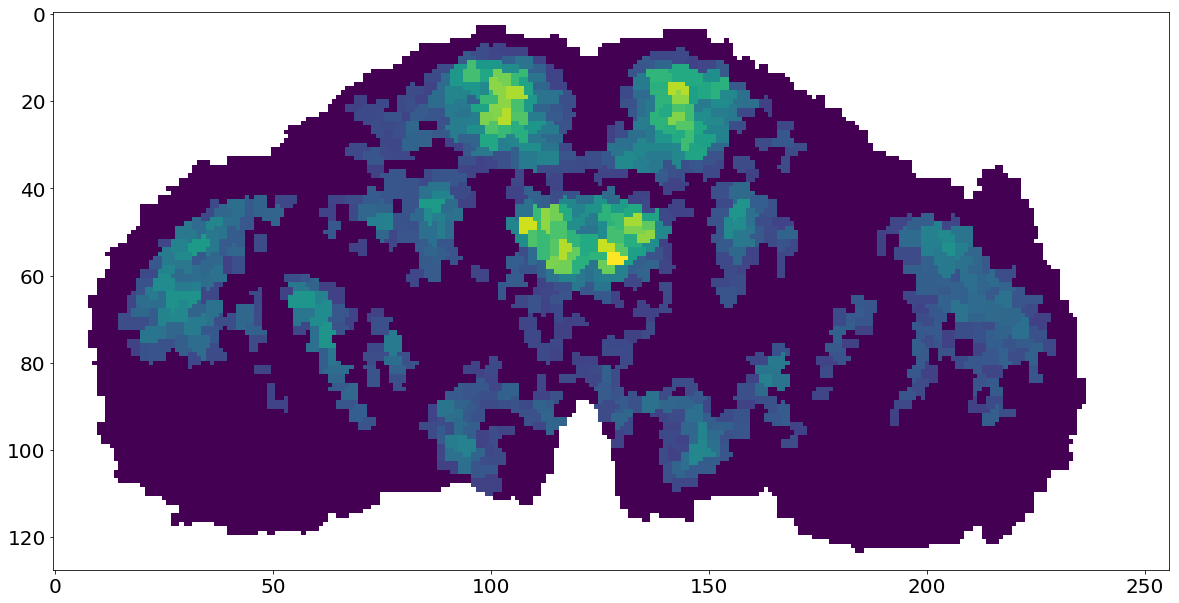

In [461]:
fig = plt.figure(figsize=(20,20))
plt.imshow(map_y_pos[20,:,:].T)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


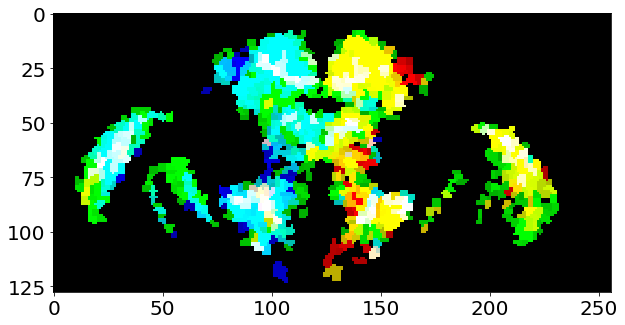

In [244]:
norm_min = 0
norm_max = np.max(np.nan_to_num(map_z_neg))
z=25
colors1 = Normalize(norm_min, norm_max)(map_z_neg[z,:,:].T)
colors2 = Normalize(norm_min, norm_max)(map_z_pos[z,:,:].T)
colors3 = Normalize(norm_min, norm_max)(map_y_pos[z,:,:].T)

empty = np.zeros(colors1.shape)
to_plot = np.stack((colors1,colors3,colors2),axis=2)

fig = plt.figure(figsize=(10,10))
plt.imshow(to_plot*3)

In [246]:
np.max(map_z_neg[z-1:z+1,:,:],axis=0).shape

(256, 128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


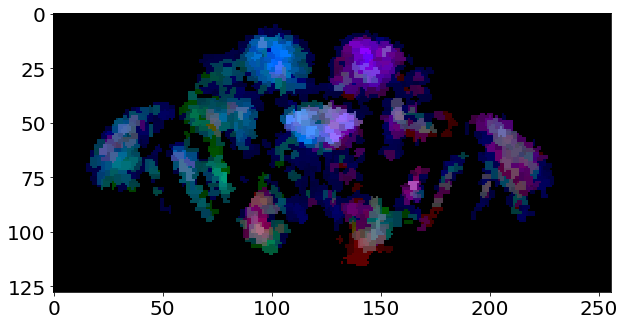

In [293]:
norm_min = 0
norm_max = np.max(np.nan_to_num(map_z_neg))
z=20
z_ = 1
colors1 = Normalize(norm_min, norm_max)(np.max(map_z_neg[z-z_:z+z_,:,:],axis=0).T)
colors2 = Normalize(norm_min, norm_max)(np.max(map_z_pos[z-z_:z+z_,:,:],axis=0).T)
colors3 = Normalize(norm_min, norm_max)(np.max(map_y_pos[z-z_:z+z_,:,:],axis=0).T)

empty = np.zeros(colors1.shape)
to_plot = np.stack((colors1,colors2,colors3),axis=2)

fig = plt.figure(figsize=(10,10))
plt.imshow(to_plot)

In [26]:
norm_min = 0
norm_max = np.max(np.nan_to_num(map_z_neg))
z=18
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(map_z_neg_smo[z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(map_z_pos_smo[z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(map_y_pos_smo[z,:,:].T)

    empty = np.zeros(colors1.shape)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)

#fig = plt.figure(figsize=(10,10))
#plt.imshow(to_plot*2)

In [30]:
norm_min = 0
norm_max = np.max(np.nan_to_num(map_z_neg))
z=18
slices = []
for z in range(49):
    colors1 = Normalize(norm_min, norm_max)(map_z_neg[z,:,:].T)
    colors2 = Normalize(norm_min, norm_max)(map_z_pos[z,:,:].T)
    colors3 = Normalize(norm_min, norm_max)(map_y_pos[z,:,:].T)

    empty = np.zeros(colors1.shape)
    to_plot = np.stack((colors1,colors2,colors3),axis=2)
    slices.append(to_plot)

#fig = plt.figure(figsize=(10,10))
#plt.imshow(to_plot*2)

In [27]:
np.shape(slices)

(49, 128, 256, 3)

In [24]:
slices = np.moveaxis(np.moveaxis(slices,0,2),0,1)
slices.shape

(256, 128, 49, 3)

In [30]:
save_file = os.path.join(dataset_path, '20201219_RGB_corr_map', 'B.nii')
nib.Nifti1Image(slices[:,:,:,2], np.eye(4)).to_filename(save_file)

In [39]:
warp_dir = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/anat_templates/straighten/'
transforms = os.listdir(warp_dir)
transforms = os.path.join(warp_dir, transforms[0])

In [58]:
to_warp = ants.from_numpy(slices[:,:,::-1,:])
to_warp.set_spacing((2.6,2.6,5,1))

In [59]:
out = ants.apply_transforms(to_warp, to_warp, transforms, imagetype=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

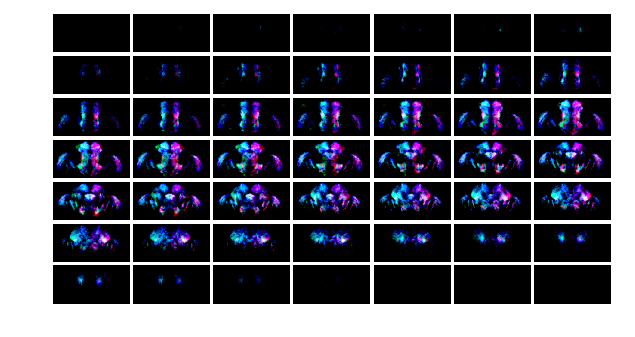

In [60]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(np.swapaxes(out[:,:,i,:],0,1)*2);
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')#

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

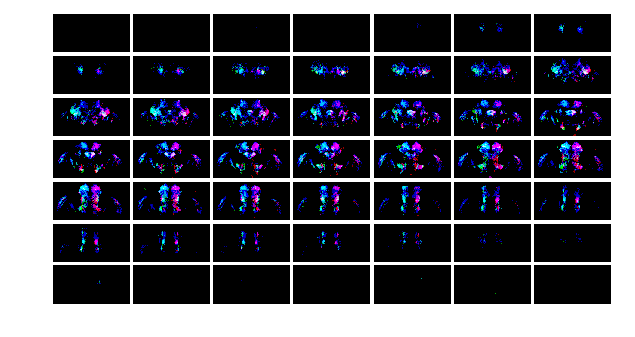

In [31]:
fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(7, 7), axes_pad=.05)
for i in range(49):
    grid[i].imshow(slices[i][:,:,:]*2);
    grid[i].axis('off')
    
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')#

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


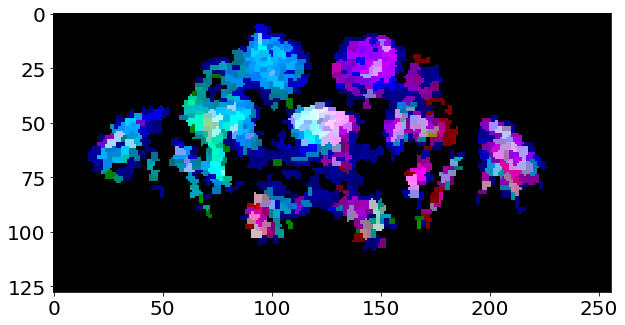

In [438]:
norm_min = 0
norm_max = np.max(np.nan_to_num(map_z_neg))
z=18
z_ = 1
colors1 = Normalize(norm_min, norm_max)(map_z_neg[z,:,:].T)
colors2 = Normalize(norm_min, norm_max)(map_z_pos[z,:,:].T)
colors3 = Normalize(norm_min, norm_max)(map_y_pos[z,:,:].T)

empty = np.zeros(colors1.shape)
to_plot = np.stack((colors1,colors2,colors3),axis=2)

fig = plt.figure(figsize=(10,10))
plt.imshow(to_plot*2)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [492]:
norm_min = 0
norm_max = np.max(np.nan_to_num(map_z_neg))
z=20
colors1 = Normalize(norm_min, norm_max)(map_z_neg_smo)
colors2 = Normalize(norm_min, norm_max)(map_z_pos_smo)
colors3 = Normalize(norm_min, norm_max)(map_y_pos_smo)

empty_alpha = np.ones(colors1.shape)

#to_plot = np.stack((colors1,colors2,colors3,empty_alpha),axis=3)
to_plot = np.stack((colors1,colors2,colors3),axis=3)



In [486]:
slices = np.asarray(slices)
to_plot = np.stack((slices,empty_alpha),axis=3)


ValueError: all input arrays must have the same shape

In [485]:
np.shape(slices)

(49, 128, 256, 3)

In [493]:
max_to_plot = np.swapaxes(np.max(np.nan_to_num(to_plot),axis=0)*1,0,1)

In [494]:
max_to_plot[np.where(np.sum(max_to_plot[:,:,:2],axis=-1)==0)] = 0

In [495]:
test = cv2.resize(max_to_plot, dsize=(int(1024*0.65),int(512*0.65)), interpolation=cv2.INTER_NEAREST)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


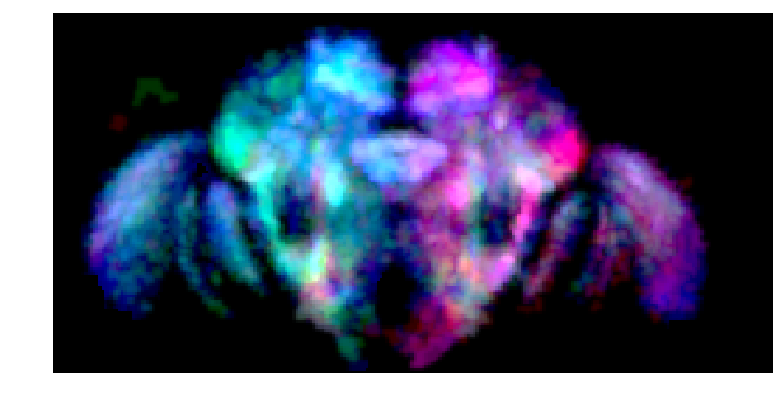

In [496]:
### Main Fig ###
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([1,1,1,1])
ax.axis('off')
ax.imshow(anatomy_XY,cmap='gray')
ax.imshow(test*1.5)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot()

ax.scatter(map_z_neg.ravel(), map_z_pos.ravel(), map_y_pos.ravel(),s=1,color='k')
ax.view_init(30, 50)

ax.set_xlabel('Right Turn')
ax.set_ylabel('Left Turn')
ax.set_zlabel('Forward')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

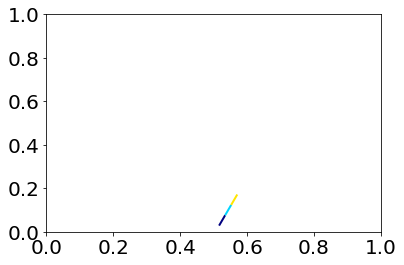

In [390]:
import matplotlib.collections as mcoll
import matplotlib.path as mpath

def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    ax = plt.gca()
    ax.add_collection(lc)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

N = 2
np.random.seed(101)
x = np.random.rand(N)
y = np.random.rand(N)
fig, ax = plt.subplots()

path = mpath.Path(np.column_stack([x, y]))
verts = path.interpolated(steps=3).vertices
x, y = verts[:, 0], verts[:, 1]
z = np.linspace(0, 1, len(x))
colorline(x, y, z, cmap=plt.get_cmap('jet'), linewidth=2)

# Create color cube

In [422]:
from mpl_toolkits.mplot3d import Axes3D

In [428]:
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors

def multicolored_lines():
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    """

    x = np.linspace(0, 1, 100)
    y = x
    #fig, ax = plt.subplots(projection='3d')

    lc = colorline(x, y, cmap=black_blue)
    #plt.colorbar(lc)
    #plt.xlim(x.min(), x.max())
    #plt.ylim(-1.0, 1.0)
    #plt.show()

def colorline(
        x, y, z=None, cmap='copper', norm=plt.Normalize(0.0, 1.0),
        linewidth=6, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    # to check for numerical input -- this is a hack
    if not hasattr(z, "__iter__"):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

multicolored_lines()

AttributeError: 'LineCollection' object has no attribute 'do_3d_projection'

<Figure size 720x720 with 1 Axes>

In [401]:
plt.register_cmap(name='rvb', data=rvb)  # optional lut kwarg

In [405]:
rvb

In [409]:

def make_colormap(seq):
    """Return a LinearSegmen?tedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)


c = mcolors.ColorConverter().to_rgb
#rvb = make_colormap(
#    [c('red'), c('violet'), 0.33, c('violet'), c('blue'), 0.66, c('blue')])
black_blue = make_colormap([c('black'), c('blue')])



# N = 1000
# array_dg = np.random.uniform(0, 10, size=(N, 2))
# colors = np.random.uniform(-2, 2, size=(N,))
# plt.scatter(array_dg[:, 0], array_dg[:, 1], c=colors, cmap=rvb)
# plt.colorbar()

In [397]:
c('blue')

(0.0, 0.0, 1.0)

In [26]:
turn_map = np.maximum(map_z_neg, map_z_pos)

(0, 15000)

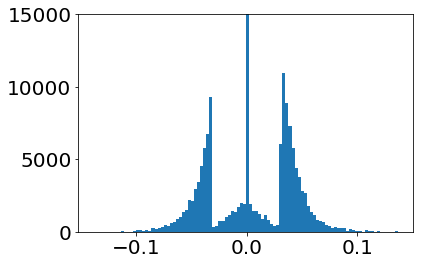

In [160]:
plt.hist(final_map.ravel(),bins=100);
plt.ylim(0,15000)

In [171]:
final_map = final_map *-1

In [180]:
z_neg_map = final_map.copy()

In [195]:
Y_map = final_map.copy()

In [187]:
final_map.shape

(49, 256, 128)

In [186]:
final_map = np.maximum(z_neg_map, z_pos_map)

In [191]:
turn_map = final_map.copy()

In [207]:
final_map = turn_map-Y_map

In [210]:
z_neg_map.shape

(49, 256, 128)

In [328]:
all_map = np.maximum(turn_map, Y_map)

In [220]:
test = np.where(z_neg_map >= z_pos_map, z_neg_map, -z_pos_map)

In [336]:
final_map = turn_map

In [345]:
final_map = Y_map

In [342]:
final_map = all_map

In [516]:
anatomy_XY = cv2.resize(np.max(anatomy,axis=2), dsize=(int(512*0.65), int(1024*0.65)), interpolation=cv2.INTER_CUBIC).T
anatomy_XZ = cv2.resize(np.max(anatomy,axis=1), dsize=(256, int(1024*0.65)), interpolation=cv2.INTER_CUBIC).T
anatomy_YZ = cv2.resize(np.max(anatomy,axis=0), dsize=(256, int(512*0.65)), interpolation=cv2.INTER_CUBIC)[:,::-1]

map_XY = cv2.resize(np.max(np.nan_to_num(final_map),axis=0), dsize=(int(512*0.65), int(1024*0.65)), interpolation=cv2.INTER_NEAREST).T
map_XZ = cv2.resize(np.max(np.nan_to_num(final_map),axis=2), dsize=(int(1024*0.65),256), interpolation=cv2.INTER_NEAREST)
map_YZ = cv2.resize(np.max(np.nan_to_num(final_map),axis=1), dsize=(int(512*0.65),256), interpolation=cv2.INTER_NEAREST).T[:,::-1]

# map_XY = cv2.resize(np.abs(np.min(np.nan_to_num(final_map),axis=0)), dsize=(int(512*0.65), int(1024*0.65)), interpolation=cv2.INTER_NEAREST).T
# map_XZ = cv2.resize(np.abs(np.min(np.nan_to_num(final_map),axis=2)), dsize=(int(1024*0.65),256), interpolation=cv2.INTER_NEAREST)
# map_YZ = cv2.resize(np.abs(np.min(np.nan_to_num(final_map),axis=1)), dsize=(int(512*0.65),256), interpolation=cv2.INTER_NEAREST).T[:,::-1]

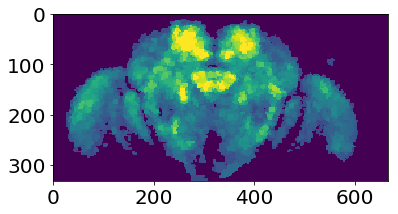

In [349]:
plt.imshow(map_XY_turn_pos,vmax=.15)#Y

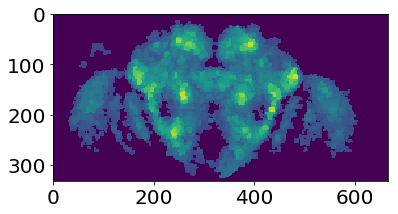

In [338]:
plt.imshow(map_XY,vmax=.15)#turn

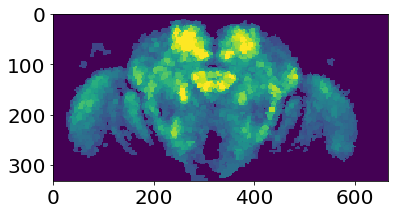

In [348]:
plt.imshow(map_XY_turn_all,vmax=.15)#all

In [344]:
#all map
map_XY_turn_all = map_XY.copy()
map_XZ_turn_all = map_XZ.copy()
map_YZ_turn_all = map_YZ.copy()

In [347]:
#y_map
map_XY_turn_pos = map_XY.copy()
map_XZ_turn_pos = map_XZ.copy()
map_YZ_turn_pos = map_YZ.copy()

In [352]:
temp = np.where(map_XY_turn_all == map_XY_turn_pos)
map_XY_turn_all[temp] = map_XY_turn_all[temp]*-1

temp = np.where(map_XZ_turn_all == map_XZ_turn_pos)
map_XZ_turn_all[temp] = map_XZ_turn_all[temp]*-1

temp = np.where(map_YZ_turn_all == map_YZ_turn_pos)
map_YZ_turn_all[temp] = map_YZ_turn_all[temp]*-1

In [353]:
map_XY = map_XY_turn_all
map_XZ = map_XZ_turn_all
map_YZ = map_YZ_turn_all

In [356]:
map_XY[np.where(map_XY==0)] = np.nan
map_XZ[np.where(map_XZ==0)] = np.nan
map_YZ[np.where(map_YZ==0)] = np.nan

In [237]:
map_XY=map_XY_turn_pos

In [234]:
map_XY_turn_pos = map_XY.copy()

In [231]:
map_XY_turn = map_XY.copy()

In [239]:
map_XY.shape

(332, 665)

In [240]:
test = np.where(map_XY_turn == map_XY_turn_pos)

In [242]:
map_XY = map_XY_turn

In [243]:
map_XY[test] = map_XY[test]*-1

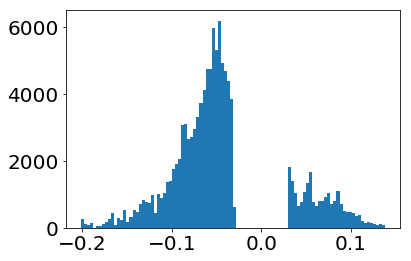

In [303]:
plt.hist(map_XY.ravel(),bins=100);

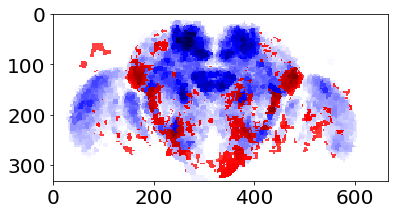

In [357]:
plt.imshow(map_XY,cmap='seismic')

In [255]:
np.sum(np.isnan(map_XY))

0

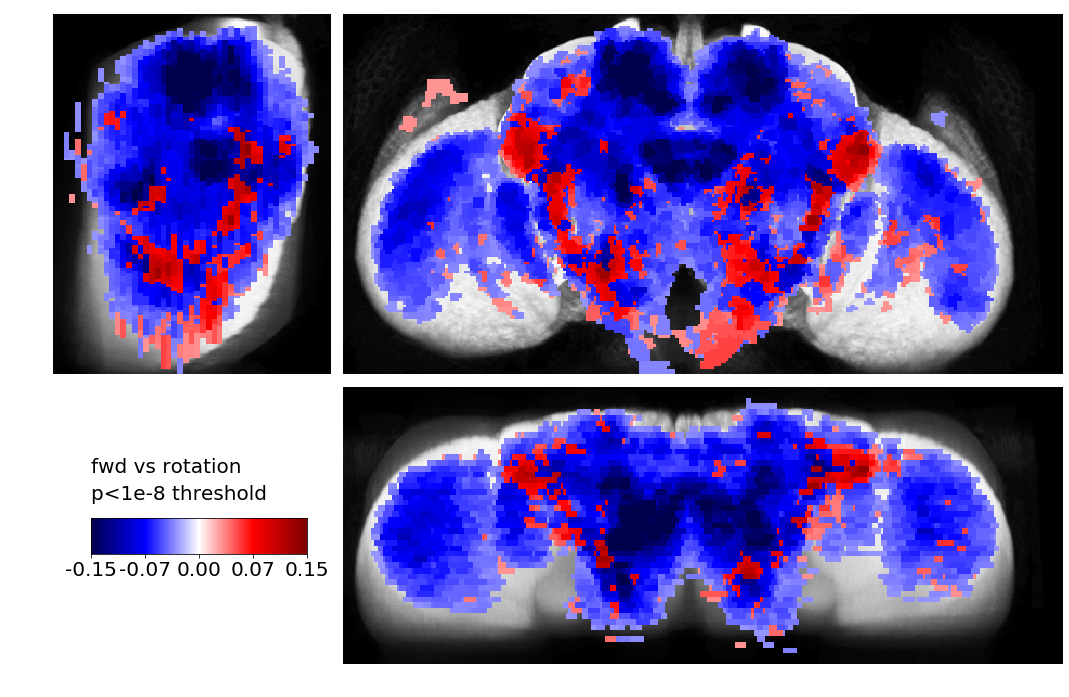

In [361]:
### Setup to plot 2-color plots

fig = plt.figure(figsize=(10,10))

# alpha_min = 0
# alpha_max = .0001
# norm_min = 0
# norm_max = .2

alpha_min = -.9
alpha_max = -.89999
norm_min = -.15
norm_max = .15

### Main Fig ###
ax = fig.add_axes([1,1,1,1])
ax.axis('off')
ax.imshow(anatomy_XY,cmap='gray')
alphas = Normalize(alpha_min, alpha_max, clip=True)(map_XY)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(norm_min, norm_max)(map_XY)
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
ax.imshow(colors)
#ax.axhline(165)
#ax.axvline(258)

### Left Fig ###
ax = fig.add_axes([.54,1.25,.5,.5])
ax.axis('off')
ax.imshow(anatomy_YZ,cmap='gray')

alphas = Normalize(alpha_min, alpha_max, clip=True)(map_YZ)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(norm_min, norm_max)(map_YZ)
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
ax.imshow(colors)
#ax.axhline(165)

### Bottom Fig ###
ax = fig.add_axes([1,.54,1,1])
ax.axis('off')
ax.imshow(anatomy_XZ,cmap='gray')
# test = np.max(np.nan_to_num(final_map),axis=2)
# map_plot = test.repeat(4, axis=0).repeat(4, axis=1)
# map_plot = cv2.resize(map_plot, dsize=(1024, 256), interpolation=cv2.INTER_CUBIC)
alphas = Normalize(alpha_min, alpha_max, clip=True)(map_XZ)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(norm_min, norm_max)(map_XZ)
cmap = plt.cm.seismic
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
ax.imshow(colors)
#ax.axvline(258)

ax = fig.add_axes([.65,1,.3,.05])
num_steps = 1000
num_ticks = 5
gradient = np.linspace(norm_min, norm_max, num_steps)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('seismic'))
tick_values = ['{:0.2f}'.format(n) for n in np.linspace(norm_min, norm_max, num_ticks)]
plt.xticks(np.linspace(0,num_steps,num_ticks), tick_values)
ax.yaxis.set_ticks([])
ax.text(s='p<1e-8 threshold',x=1,y=-1.5)
ax.text(s='fwd vs rotation',x=1,y=-3)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [63]:
final_map = []
for z in range(49):
    colored_by_betas = np.zeros(256*128)
    for cluster_num in range(n_clusters):
        cluster_indicies = np.where(labels[z,:]==cluster_num)[0]

        if sig_map[z,cluster_num] <= 1 or sig_map[z,cluster_num] >= 999: #25,975
            sig = 1
        else:
            sig = 0

        if len(cluster_indicies) > 100:
            sig = np.nan
        colored_by_betas[cluster_indicies] = value_map[z,cluster_num]*sig
    colored_by_betas = colored_by_betas.reshape(256,128)
    final_map.append(colored_by_betas)
final_map = np.asarray(final_map)

In [502]:
final_map.shape

(49, 256, 128)

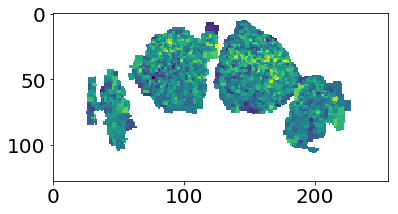

In [508]:
plt.imshow(final_map[4,:,:].T)

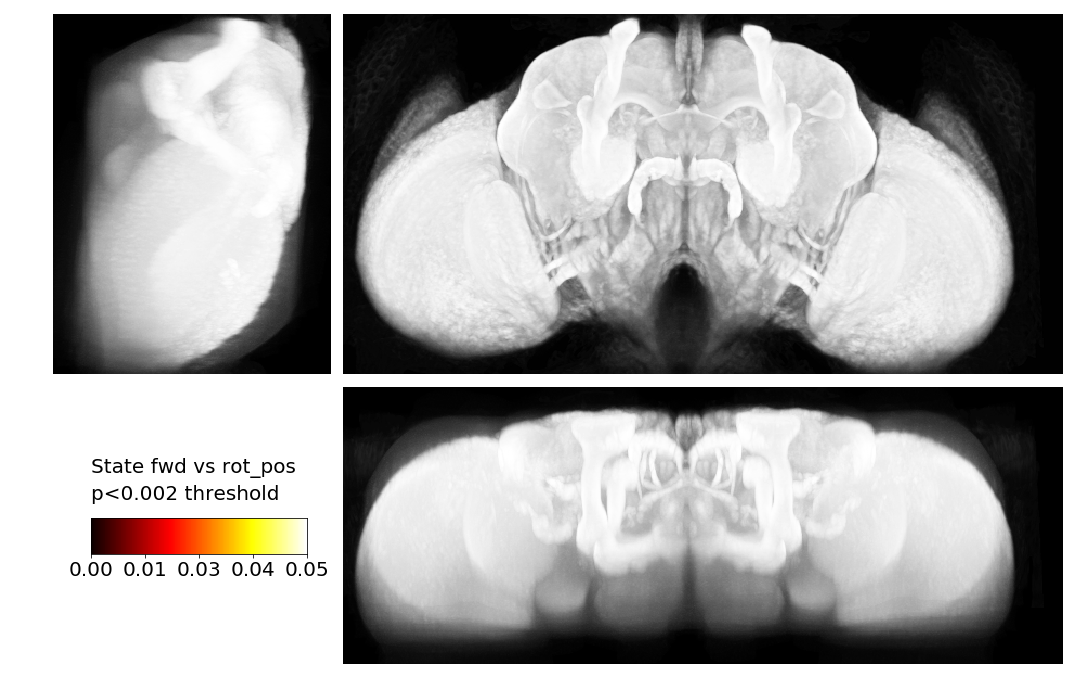

In [517]:
fig = plt.figure(figsize=(10,10))

# alpha_min = 0
# alpha_max = .0001
# norm_min = 0
# norm_max = .2

alpha_min = 0
alpha_max = .0001
norm_min = 0
norm_max = .05

### Main Fig ###
ax = fig.add_axes([1,1,1,1])
ax.axis('off')
ax.imshow(anatomy_XY,cmap='gray')
alphas = Normalize(alpha_min, alpha_max, clip=True)(map_XY)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(norm_min, norm_max)(map_XY)
cmap = plt.cm.hot
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
ax.imshow(colors)
#ax.axhline(165)
#ax.axvline(258)

### Left Fig ###
ax = fig.add_axes([.54,1.25,.5,.5])
ax.axis('off')
ax.imshow(anatomy_YZ,cmap='gray')

alphas = Normalize(alpha_min, alpha_max, clip=True)(map_YZ)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(norm_min, norm_max)(map_YZ)
cmap = plt.cm.hot
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
ax.imshow(colors)
#ax.axhline(165)

### Bottom Fig ###
ax = fig.add_axes([1,.54,1,1])
ax.axis('off')
ax.imshow(anatomy_XZ,cmap='gray')
# test = np.max(np.nan_to_num(final_map),axis=2)
# map_plot = test.repeat(4, axis=0).repeat(4, axis=1)
# map_plot = cv2.resize(map_plot, dsize=(1024, 256), interpolation=cv2.INTER_CUBIC)
alphas = Normalize(alpha_min, alpha_max, clip=True)(map_XZ)
alphas = np.clip(alphas, 0, 1)  # alpha value clipped at the bottom
# Normalize the colors b/w 0 and 1, we'll then pass an MxNx4 array to imshow
colors = Normalize(norm_min, norm_max)(map_XZ)
cmap = plt.cm.hot
colors = cmap(colors)
# Now set the alpha channel to the one we created above
colors[..., -1] = alphas
ax.imshow(colors)
#ax.axvline(258)

ax = fig.add_axes([.65,1,.3,.05])
num_steps = 1000
num_ticks = 5
gradient = np.linspace(norm_min, norm_max, num_steps)
gradient = np.vstack((gradient, gradient))
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('hot'))
tick_values = ['{:0.2f}'.format(n) for n in np.linspace(norm_min, norm_max, num_ticks)]
plt.xticks(np.linspace(0,num_steps,num_ticks), tick_values)
ax.yaxis.set_ticks([])
ax.text(s='p<0.002 threshold',x=1,y=-1.5)
ax.text(s='State fwd vs rot_pos',x=1,y=-3)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

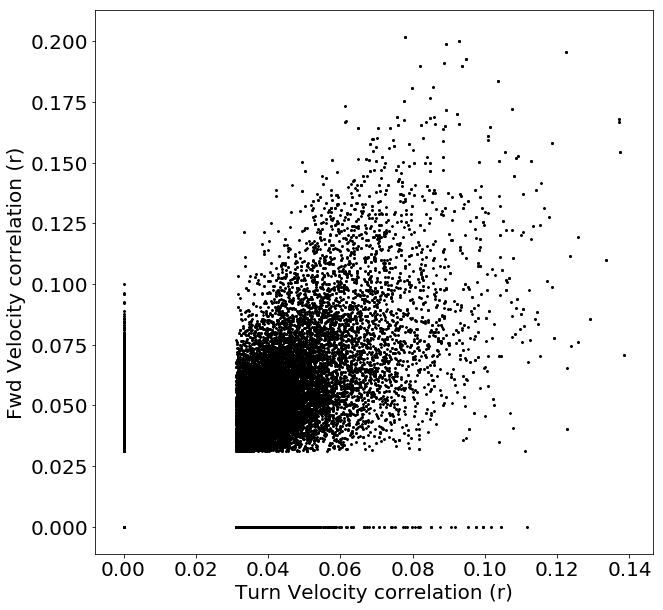

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(turn_map.ravel(), map_y_pos.ravel(),s=1,color='k')
plt.xlabel('Turn Velocity correlation (r)')
plt.ylabel('Fwd Velocity correlation (r)')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

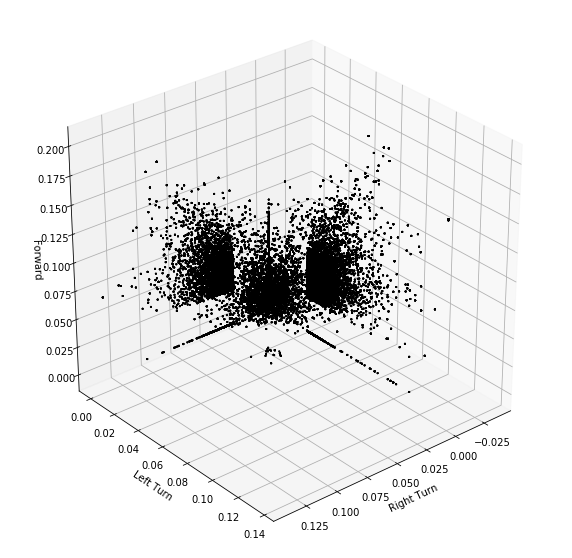

In [93]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(map_z_neg.ravel(), map_z_pos.ravel(), map_y_pos.ravel(),s=1,color='k')
ax.view_init(30, 50)

ax.set_xlabel('Right Turn')
ax.set_ylabel('Left Turn')
ax.set_zlabel('Forward')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [45]:
['{:0.2f}'.format(n) for n in np.linspace(norm_min, norm_max, num_ticks)]

['0.00', '0.05', '0.10', '0.15', '0.20']

In [38]:
np.linspace(0,1000,5)

array([   0.,  250.,  500.,  750., 1000.])

In [43]:
np.linspace(norm_min, norm_max, 5)

array([0.  , 0.05, 0.1 , 0.15, 0.2 ])

In [ ]:
np.linspace()

In [18]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [136]:
save_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201207_processed_bootstrap_maps/test'
nib.Nifti1Image(final_map.swapaxes(0,2), np.eye(4)).to_filename(save_file)

In [195]:
np.max(map_XZ)

0.13992603265461304

In [ ]:
anatomy_iso = cv2.resize(anatomy, dsize=(256, 512), interpolation=cv2.INTER_CUBIC)


In [246]:
np.max(anatomy,axis=1)

(256, 1024)

In [15]:
anatomy.shape

(1024, 512, 256)

In [238]:
test.shape

(49, 256)

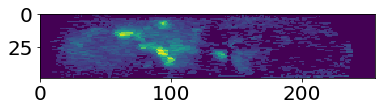

In [239]:
plt.imshow(test)

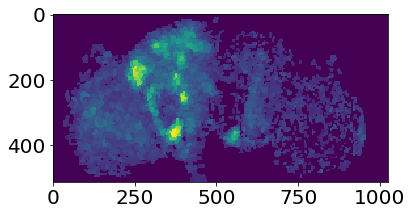

In [155]:
plt.imshow(test.repeat(4, axis=0).repeat(4, axis=1).T)

In [152]:
test.shape

(256, 128)

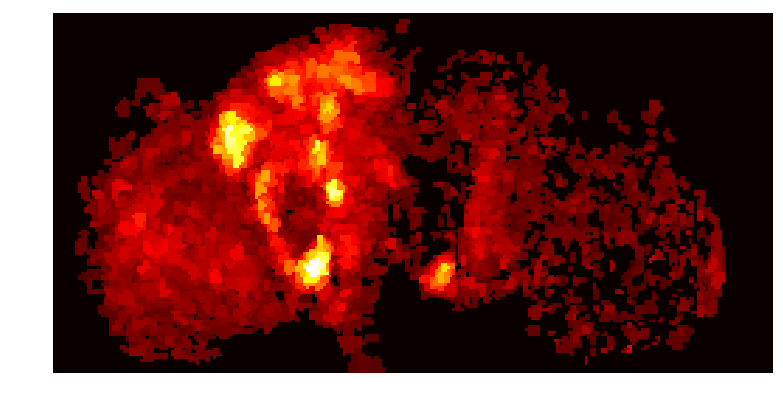

In [151]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_axes([1,1,1,1])
ax.axis('off')
test = np.max(np.nan_to_num(final_map),axis=0)
plt.imshow(test.T,cmap='hot')

# ax = fig.add_axes([1,1,.5,1])
# ax.axis('off')
# test = np.max(np.nan_to_num(final_map),axis=1)
# plt.imshow(test.T,cmap='hot')

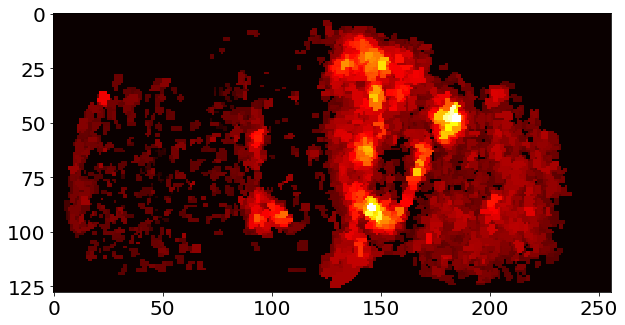

In [123]:
plt.figure(figsize=(10,10))
test = np.min(np.nan_to_num(final_map),axis=0)*-1
plt.imshow(test.T,cmap='hot')

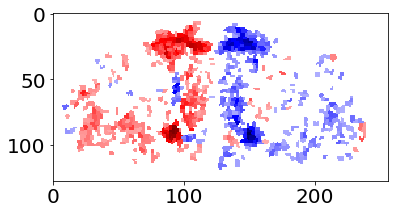

In [92]:
plt.imshow(final_map[27,:,:].T,cmap='seismic',vmin=-.1,vmax=.1)

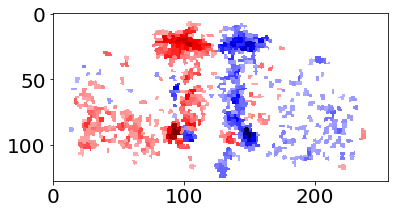

In [90]:
plt.imshow(final_map[28,:,:].T,cmap='seismic',vmin=-.1,vmax=.1)

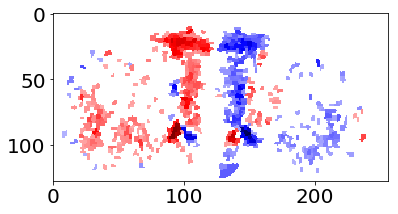

In [91]:
plt.imshow(final_map[29,:,:].T,cmap='seismic',vmin=-.1,vmax=.1)

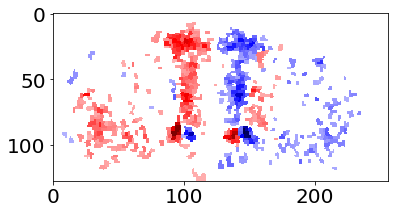

In [63]:
plt.imshow(colored_by_betas.T,cmap='seismic',vmin=-.1,vmax=.1)